# Non GPU Execution

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Load MATLAB data
mat_data = scipy.io.loadmat('5e128x128SphericGFDefaultSNR40.mat')

# Access the hyperspectral data and ground truth endmembers
hyperspectral_data = mat_data['syntheticImageNoisy']
endmembers_gt = mat_data['endmembersGT']

# Reshape the data for the neural network
height, width, bands = hyperspectral_data.shape
data_for_nn = hyperspectral_data.reshape((height * width, bands))

# Convert to PyTorch tensors
data_tensor = torch.Tensor(data_for_nn)
endmembers_gt_tensor = torch.Tensor(endmembers_gt)

# Assuming data_tensor has more samples than endmembers_gt_tensor
num_samples_to_keep = endmembers_gt_tensor.size(0)

# Adjust the size of data_tensor
data_tensor = data_tensor[:num_samples_to_keep]

# Combine data and ground truth endmembers into a single dataset
nn_dataset = TensorDataset(data_tensor, endmembers_gt_tensor)

# Define the CNN-based neural network model
class CNNEndmemberPredictionNet(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CNNEndmemberPredictionNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)  # Added layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * (bands // 8), 256)
        self.fc2 = nn.Linear(256, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))  # Added layer
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the CNN model with a specified input_channels and output_size
input_channels = bands  # Assuming each band as a channel
cnn_model = CNNEndmemberPredictionNet(input_channels, endmembers_gt.shape[1])

# Define loss function and optimizer
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Convert the data to a DataLoader
nn_loader = DataLoader(nn_dataset, batch_size=40, shuffle=True)

# Training loop
num_epochs = 1000 # Reduced the number of epochs
for epoch in range(num_epochs):
    for inputs, targets in nn_loader:
        inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = cnn_model(inputs)

        # Mean Squared Error (MSE) Loss
        loss_mse = criterion_mse(outputs, targets)

        # Spectral Angle Mapper (SAM) Loss
        normalized_outputs = F.normalize(outputs, p=2, dim=1)
        normalized_targets = F.normalize(targets, p=2, dim=1)
        cos_similarity = F.cosine_similarity(normalized_outputs, normalized_targets, dim=1)
        loss_sam = 1 - cos_similarity.mean()

        # Spectral Information Divergence (SID) Loss
        epsilon = 1e-8
        loss_sid = torch.sum(targets * torch.log((targets + epsilon) / (outputs + epsilon)))
        
        # Spectral Angle Divergence (SAD) Loss
        sin_similarity = torch.sqrt(1 - cos_similarity**2)
        loss_sad = sin_similarity.mean()

        # Root Mean Squared Error (RMSE) Loss
        loss_rmse = torch.sqrt(loss_mse)

        # Display losses
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch Loss - MSE: {loss_mse.item():.12f}, SAM: {loss_sam.item():.12f}, SID: {loss_sid.item():.12f}, SAD: {loss_sad.item():.12f}, RMSE: {loss_rmse.item():.12f}")

        loss_mse.backward()
        optimizer.step()

# Evaluate the model on the entire dataset
with torch.no_grad():
    predictions = cnn_model(data_tensor.unsqueeze(1))  # Add a channel dimension


Epoch 1/1000, Batch Loss - MSE: 0.151691898704, SAM: 0.993706166744, SID: nan, SAD: 0.999954342842, RMSE: 0.389476448298
Epoch 2/1000, Batch Loss - MSE: 0.131612315774, SAM: 0.603871405125, SID: nan, SAD: 0.918176293373, RMSE: 0.362784117460
Epoch 3/1000, Batch Loss - MSE: 0.119302958250, SAM: 0.452421844006, SID: nan, SAD: 0.836723148823, RMSE: 0.345402598381
Epoch 4/1000, Batch Loss - MSE: 0.100889727473, SAM: 0.356769919395, SID: nan, SAD: 0.765612244606, RMSE: 0.317631423473
Epoch 5/1000, Batch Loss - MSE: 0.090161800385, SAM: 0.284585535526, SID: nan, SAD: 0.698576271534, RMSE: 0.300269544125
Epoch 6/1000, Batch Loss - MSE: 0.077359251678, SAM: 0.221871078014, SID: nan, SAD: 0.627884685993, RMSE: 0.278135329485
Epoch 7/1000, Batch Loss - MSE: 0.069199085236, SAM: 0.168693900108, SID: nan, SAD: 0.555436193943, RMSE: 0.263057202101
Epoch 8/1000, Batch Loss - MSE: 0.058566987514, SAM: 0.125411391258, SID: nan, SAD: 0.484214305878, RMSE: 0.242006182671
Epoch 9/1000, Batch Loss - MSE: 

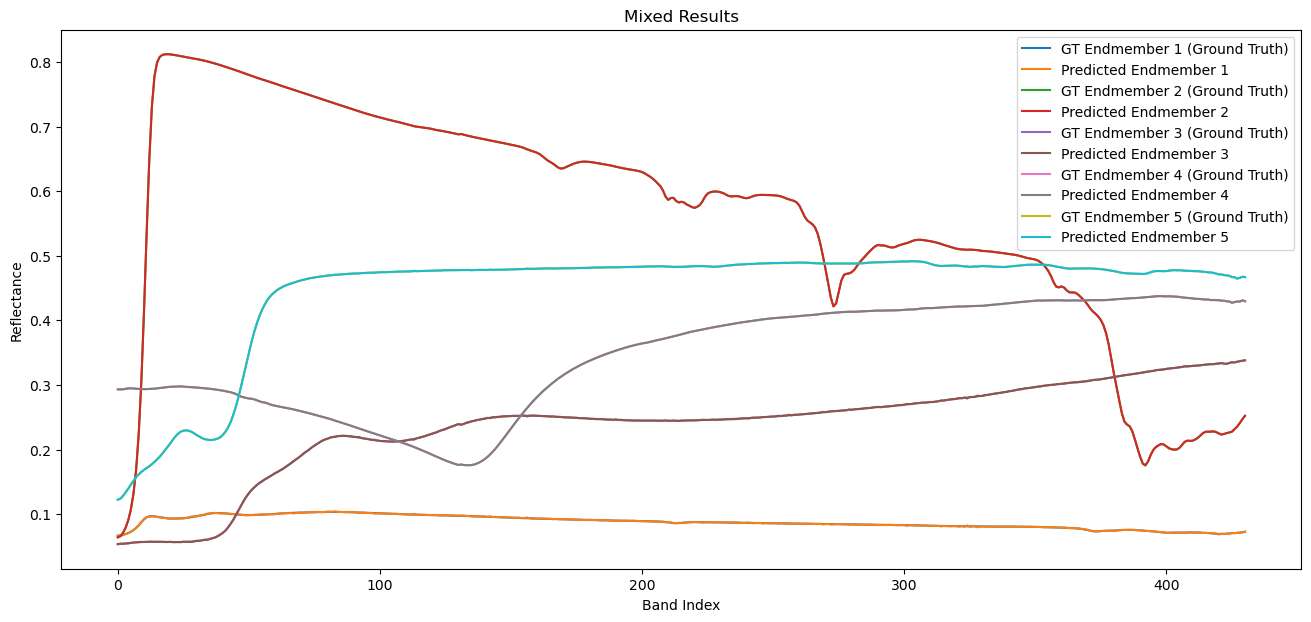

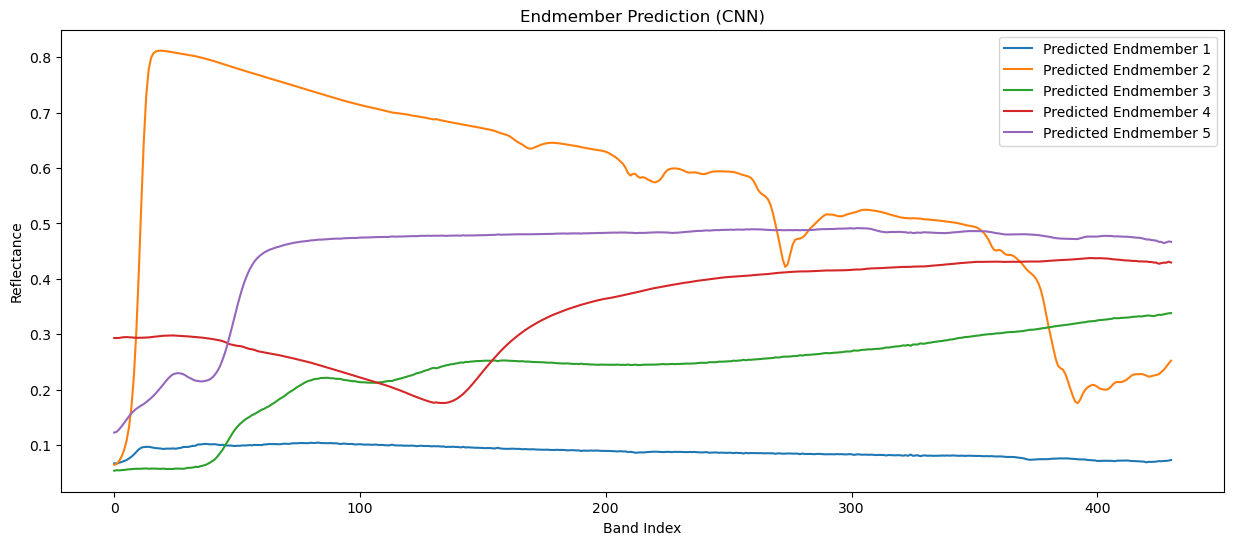

In [4]:
import matplotlib.pyplot as plt
# Visualize the predicted and ground truth endmembers
plt.figure(figsize=(16, 7))
for i in range(endmembers_gt.shape[0]):
    plt.plot(endmembers_gt[ i,:], label=f'GT Endmember {i + 1} (Ground Truth)')
    plt.plot(predictions[ i, :].numpy(), linestyle='solid', label=f'Predicted Endmember {i + 1}')
plt.title('Mixed Results')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# Visualize the predicted and ground truth endmembers
plt.figure(figsize=(15, 6))
for i in range(endmembers_gt.shape[0]):
    plt.plot(predictions[ i, :].numpy(), linestyle='solid', label=f'Predicted Endmember {i + 1}')

plt.title('Endmember Prediction (CNN)')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# GPU Enabled Execution


In [3]:
import torch
print(torch.cuda.is_available())


True


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MATLAB data
mat_data = scipy.io.loadmat('5e128x128SphericGFDefaultSNR40.mat')

# Access the hyperspectral data and ground truth endmembers
hyperspectral_data = mat_data['syntheticImageNoisy']
endmembers_gt = mat_data['endmembersGT']

# Reshape the data for the neural network
height, width, bands = hyperspectral_data.shape
data_for_nn = hyperspectral_data.reshape((height * width, bands))

# Convert to PyTorch tensors
data_tensor = torch.Tensor(data_for_nn)
endmembers_gt_tensor = torch.Tensor(endmembers_gt)

# Assuming data_tensor has more samples than endmembers_gt_tensor
num_samples_to_keep = endmembers_gt_tensor.size(0)

# Adjust the size of data_tensor
data_tensor = data_tensor[:num_samples_to_keep]

# Combine data and ground truth endmembers into a single dataset
nn_dataset = TensorDataset(data_tensor, endmembers_gt_tensor)

# Define the CNN-based neural network model
class CNNEndmemberPredictionNet(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CNNEndmemberPredictionNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)  # Added layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * (bands // 8), 256)
        self.fc2 = nn.Linear(256, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))  # Added layer
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the CNN model with a specified input_channels and output_size
input_channels = bands  # Assuming each band as a channel
cnn_model = CNNEndmemberPredictionNet(input_channels, endmembers_gt.shape[1]).to(device)

# Define loss function and optimizer
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Convert the data to a DataLoader
nn_loader = DataLoader(nn_dataset, batch_size=40, shuffle=True)

# Training loop
num_epochs = 2000  # Reduced the number of epochs
for epoch in range(num_epochs):
    for inputs, targets in nn_loader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(1)  # Add a channel dimension

        optimizer.zero_grad()
        outputs = cnn_model(inputs)

        # Mean Squared Error (MSE) Loss
        loss_mse = criterion_mse(outputs, targets)

        # Spectral Angle Mapper (SAM) Loss
        normalized_outputs = F.normalize(outputs, p=2, dim=1)
        normalized_targets = F.normalize(targets, p=2, dim=1)
        cos_similarity = F.cosine_similarity(normalized_outputs, normalized_targets, dim=1)
        loss_sam = 1 - cos_similarity.mean()

        # Spectral Information Divergence (SID) Loss
        epsilon = 1e-8
        loss_sid = torch.sum(targets * torch.log((targets + epsilon) / (outputs + epsilon)))

        # Spectral Angle Divergence (SAD) Loss
        sin_similarity = torch.sqrt(1 - cos_similarity**2)
        loss_sad = sin_similarity.mean()

        # Root Mean Squared Error (RMSE) Loss
        loss_rmse = torch.sqrt(loss_mse)

        # Display losses
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch Loss - MSE: {loss_mse.item():.12f}, SAM: {loss_sam.item():.12f}, SID: {loss_sid.item():.12f}, SAD: {loss_sad.item():.12f}, RMSE: {loss_rmse.item():.12f}")

        loss_mse.backward()
        optimizer.step()

# Evaluate the model on the entire dataset
with torch.no_grad():
    predictions = cnn_model(data_tensor.unsqueeze(1).to(device))  # Add a channel dimension and move data to GPU


Epoch 1/1000, Batch Loss - MSE: 0.154964953661, SAM: 1.124459505081, SID: nan, SAD: 0.992029130459, RMSE: 0.393655896187
Epoch 2/1000, Batch Loss - MSE: 0.129688724875, SAM: 0.586044669151, SID: nan, SAD: 0.910240769386, RMSE: 0.360123217106
Epoch 3/1000, Batch Loss - MSE: 0.125181153417, SAM: 0.425960898399, SID: nan, SAD: 0.818787574768, RMSE: 0.353809475899
Epoch 4/1000, Batch Loss - MSE: 0.096977539361, SAM: 0.333970308304, SID: nan, SAD: 0.745860517025, RMSE: 0.311412155628
Epoch 5/1000, Batch Loss - MSE: 0.089327700436, SAM: 0.262074291706, SID: nan, SAD: 0.674769103527, RMSE: 0.298877388239
Epoch 6/1000, Batch Loss - MSE: 0.076242141426, SAM: 0.200216829777, SID: nan, SAD: 0.600086510181, RMSE: 0.276119798422
Epoch 7/1000, Batch Loss - MSE: 0.063503317535, SAM: 0.149702072144, SID: nan, SAD: 0.525941491127, RMSE: 0.251998633146
Epoch 8/1000, Batch Loss - MSE: 0.060204360634, SAM: 0.109686851501, SID: nan, SAD: 0.454691976309, RMSE: 0.245365768671
Epoch 9/1000, Batch Loss - MSE: 

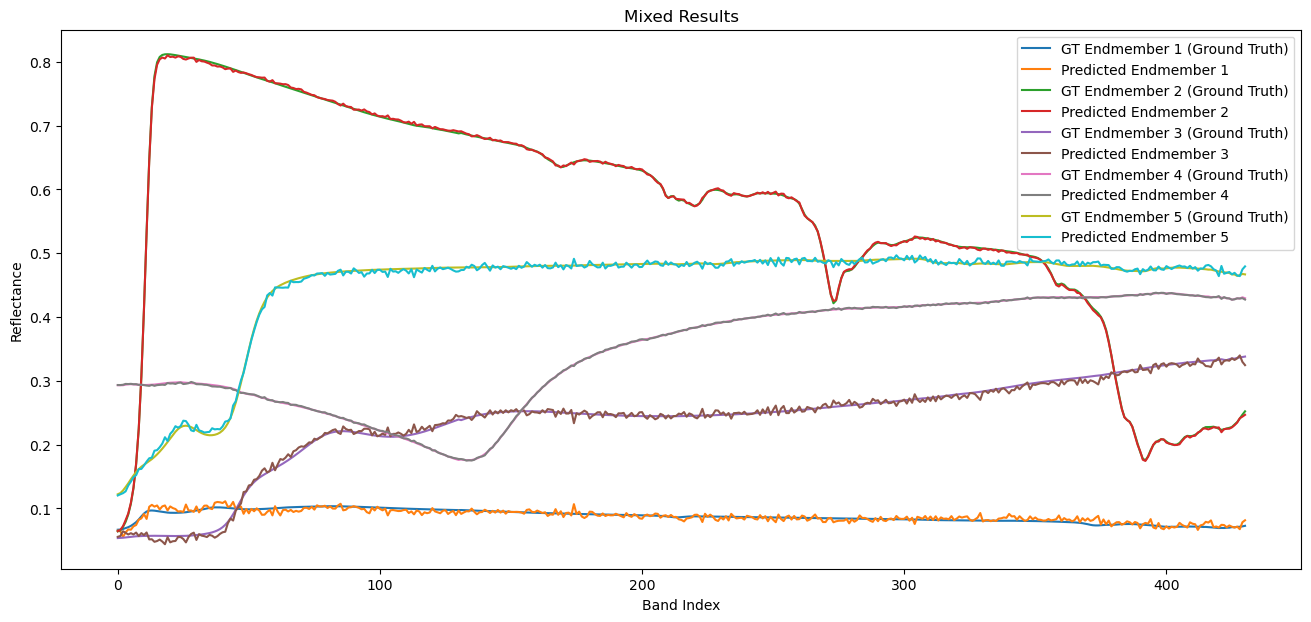

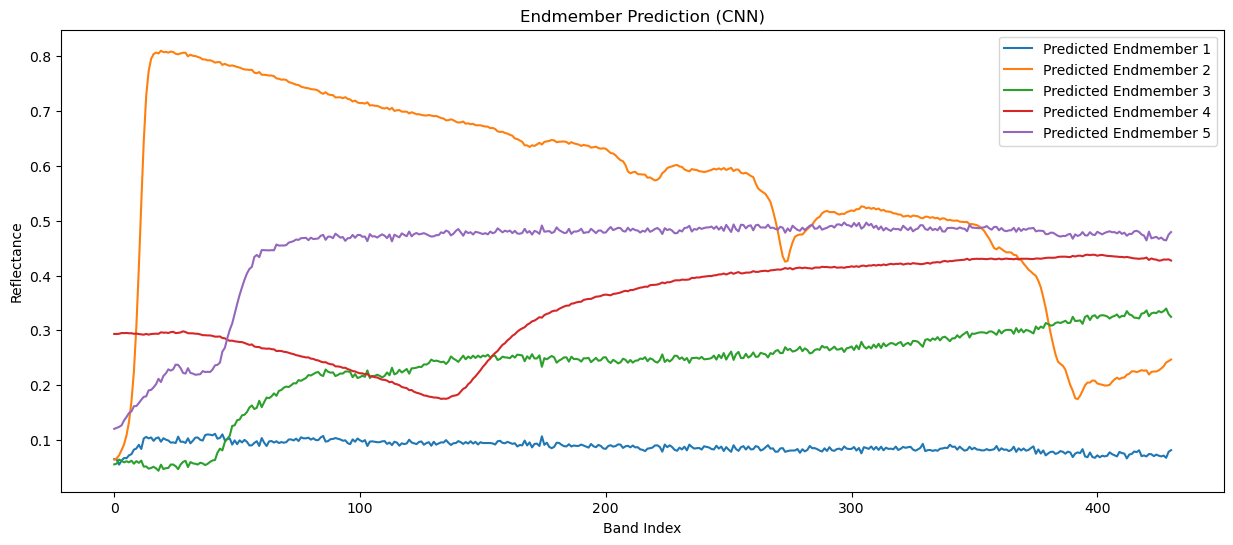

In [7]:
import matplotlib.pyplot as plt

# Visualize the predicted and ground truth endmembers
plt.figure(figsize=(16, 7))
for i in range(endmembers_gt.shape[0]):
    plt.plot(endmembers_gt[i, :], label=f'GT Endmember {i + 1} (Ground Truth)')
    plt.plot(predictions[i, :].cpu().numpy(), linestyle='solid', label=f'Predicted Endmember {i + 1}')
plt.title('Mixed Results')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

# Visualize the predicted endmembers only
plt.figure(figsize=(15, 6))
for i in range(endmembers_gt.shape[0]):
    plt.plot(predictions[i, :].cpu().numpy(), linestyle='solid', label=f'Predicted Endmember {i + 1}')

plt.title('Endmember Prediction (CNN)')
plt.xlabel('Band Index')
plt.ylabel('Reflectance')
plt.legend()
plt.show()
